<a href="https://colab.research.google.com/github/Minupama/PatternRecognition_Assignment/blob/main/VGG16_defungi_210696A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code is used to connect the Google Drive to Google colab notebook.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models

In [ ]:
# Paths for Google Drive and dataset
drive_path = "/content/drive/MyDrive/defungi"  # Update if needed
base_dir = "/content/defungi_split"           # Local directory for train/val/test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")



In [ ]:
# Step 1: Create directories for train, val, and test
def create_split_dirs():
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)


In [ ]:

# Step 2: Split dataset into train, validation, and test
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.6, val_ratio=0.2, seed=123):
    subfolders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

    for subfolder in subfolders:
        subfolder_path = os.path.join(source_dir, subfolder)

        # Check if there are images in the subfolder
        images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
        if len(images) == 0:
            print(f"Warning: No images found in {subfolder}. Skipping...")
            continue  # Skip subfolder if no images

        # Split images into train, validation, and test
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=seed)
        val_images, test_images = train_test_split(temp_images, test_size=val_ratio/(1-train_ratio), random_state=seed)

        # Copy images to respective folders
        for image_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
            class_dir = os.path.join(target_dir, subfolder)
            os.makedirs(class_dir, exist_ok=True)
            for image in image_set:
                shutil.copy(os.path.join(subfolder_path, image), os.path.join(class_dir, image))

# Prepare directories
create_split_dirs()
split_dataset(drive_path, train_dir, val_dir, test_dir)

In [ ]:
# Step 3: Preprocessing images using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)




Found 5066 images belonging to 5 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_steps = val_generator.samples // val_generator.batch_size
import math
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)


Found 1690 images belonging to 5 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1691 images belonging to 5 classes.


In [ ]:
# Step 4: Setting up VGG16 model
from tensorflow.keras import applications

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Freeze layers of VGG16 base model
for layer in base_model.layers:
    layer.trainable = False
# Add custom layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

In [ ]:
# Create the final model
model = models.Model(inputs=base_model.input, outputs=x)

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1  # To display progress
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 65s 309ms/step - accuracy: 0.5201 - loss: 1.1433 - val_accuracy: 0.5828 - val_loss: 0.9663
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.5916 - loss: 0.9786 - val_accuracy: 0.6095 - val_loss: 0.9255
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6047 - loss: 0.9284 - val_accuracy: 0.6160 - val_loss: 0.9015
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.6074 - loss: 0.9223 - val_accuracy: 0.6148 - val_loss: 0.9080
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.6272 - loss: 0.8977 - val_accuracy: 0.6343 - val_loss: 0.8811
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.6276 - loss: 0.8983 - val_accuracy: 0.6467 - val_loss: 0.8411
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.6455 - loss: 0.8349 - val_accuracy: 0.6609 - val_loss: 0.8410
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.6420 - loss: 0.8740 - val

In [ ]:
# Step 7: Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.6481 - loss: 0.8160
Test accuracy: 65.75%


In [ ]:
# Optionally: Save the model
model.save('/content/vgg16_model.h5')

In [ ]:
# Optionally: Plot the accuracy/loss curves
import matplotlib.pyplot as plt

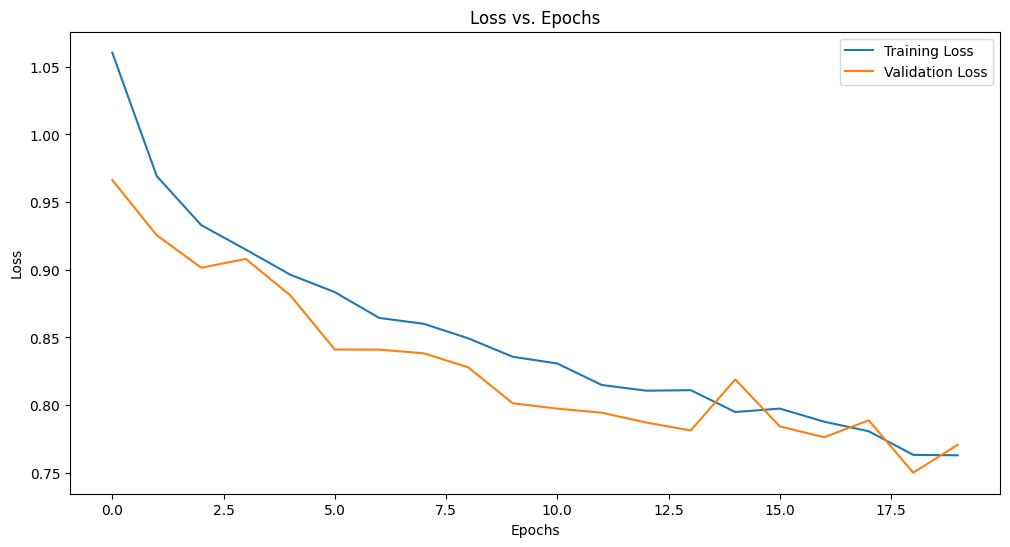

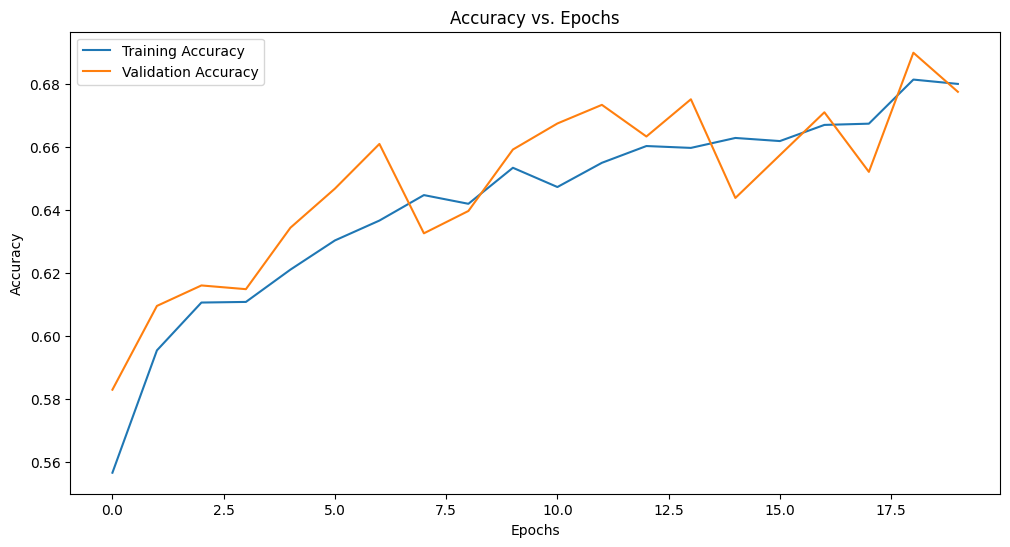

In [ ]:
#Plot Training and Validation Metrics
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels from the test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 436ms/step


In [ ]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())



# Generate a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[678  84  42  16  63]
 [354  51  23   8  31]
 [131  16   6   3   8]
 [ 24   1   2   0   2]
 [118  21   5   2   2]]


In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

          H1       0.52      0.77      0.62       883
          H2       0.29      0.11      0.16       467
          H3       0.08      0.04      0.05       164
          H5       0.00      0.00      0.00        29
          H6       0.02      0.01      0.02       148

    accuracy                           0.44      1691
   macro avg       0.18      0.19      0.17      1691
weighted avg       0.36      0.44      0.37      1691



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


Confusion Matrix:
[[678  84  42  16  63]
 [354  51  23   8  31]
 [131  16   6   3   8]
 [ 24   1   2   0   2]
 [118  21   5   2   2]]


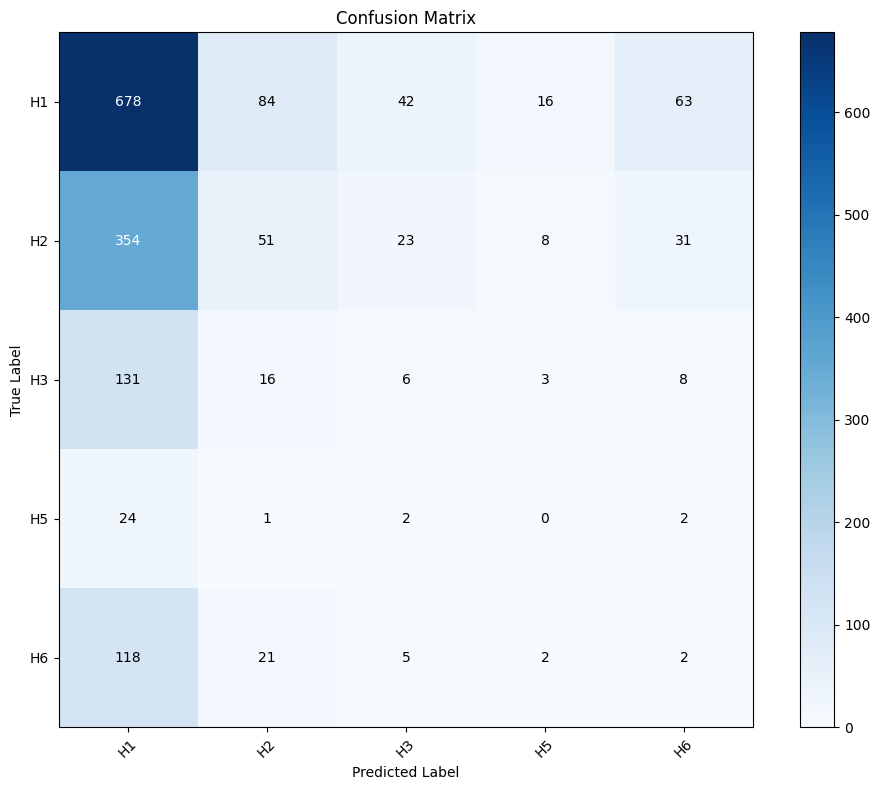

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix with Values
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(test_generator.class_indices))
class_labels = list(test_generator.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate cells with values
thresh = conf_matrix.max() / 2.0  # Set threshold for text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j, i, format(conf_matrix[i, j], 'd'),
            ha="center", va="center",
            color="white" if conf_matrix[i, j] > thresh else "black"
        )

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

